# Investigate required values

Investigate which values are needed to predict in order to fully specify a protein correctly

In [1]:
import os, sys
import functools
import itertools
import multiprocessing
import warnings
import importlib
import tempfile
from pathlib import Path
import json

from scipy import stats
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import torch

SRC_DIR = os.path.join(os.path.dirname(os.getcwd()), "foldingdiff")
assert os.path.isdir(SRC_DIR)
sys.path.append(SRC_DIR)
import datasets
import angles_and_coords as ac
import nerf
import tmalign  # So we can compare structural similarity
import plotting

datasets.LOCAL_DATA_DIR

PosixPath('/home/wukevin/projects/protdiff/data')

In [2]:
importlib.reload(datasets)

train_dset = datasets.CathCanonicalAnglesOnlyDataset(
    split='train',
    zero_center=True,
    pad=128,
    trim_strategy='randomcrop',
)
len(train_dset.filenames)

INFO:root:Loading cached full dataset from /home/wukevin/projects/protdiff/foldingdiff/cache_canonical_structures_cath_3d9c2c44b7750efc48e938ca80f3b401.pkl


INFO:root:Hash matches between codebase and cached values!
INFO:root:Removing structures shorter than 40 residues excludes 536/30931 --> 30395 sequences
INFO:root:Split train contains 24316 structures
INFO:root:Offsetting features ['phi', 'psi', 'omega', 'tau', 'CA:C:1N', 'C:1N:1CA'] by means [ 1.3271273  1.4533131  1.5187854 -1.4702034  0.0361131  3.1276708
  1.9405054  2.0354161  2.1225433]
INFO:root:Length of angles: 40-1202, mean 153.14570653067938
INFO:root:CATH canonical angles only dataset with ['phi', 'psi', 'omega', 'tau', 'CA:C:1N', 'C:1N:1CA'] (subset idx [3, 4, 5, 6, 7, 8])


24316

In [3]:
train_dset_noised = datasets.NoisedAnglesDataset(
    train_dset,
    timesteps=1000,
)
str(train_dset_noised)

INFO:root:Getting linear variance schedule with 1000 timesteps


'NoisedAnglesDataset wrapping <datasets.CathCanonicalAnglesOnlyDataset object at 0x7fce5821a820> with 24316 examples with linear-1000 with variance scales 1.0 and 1.0'

In [4]:
importlib.reload(ac)
importlib.reload(nerf)

# https://arxiv.org/pdf/2205.04676.pdf
# N:CA:C = tau

# Full spec should be angles_to_use=["N:CA:C", "CA:C:1N", "C:1N:1CA", "phi", "psi", "omega"], dists_to_use=["N:CA", "CA:C", "C:1N"]

def test_consistency(fname:str, angles_to_use=["phi", "psi", "omega", "tau", "CA:C:1N", "C:1N:1CA"], dists_to_use=["0C:1N", "N:CA", "CA:C"], visualize:bool=False):
    """Test the consistency of reconstructing a pdb file"""
    # Create the internal coordinates
    angles = ac.canonical_distances_and_dihedrals(fname, distances=dists_to_use, angles=angles_to_use)
    if angles is None:
        return np.nan, None
    with tempfile.TemporaryDirectory() as dirname:
        out_fname = os.path.join(dirname, "rebuilt_" + os.path.basename(fname))
        # rebuilt = ac.create_new_chain(
        #     out_fname, angles,
        #     angles_to_set=angles_to_use, distances_to_set=dists_to_use
        # )
        out_fname_written = ac.create_new_chain_nerf(out_fname, angles, angles_to_set=angles_to_use, dists_to_set=dists_to_use)
        if not out_fname_written:  # Failed on the way, should have returned empty string ""
            return np.nan, None
        score = tmalign.run_tmalign(fname, out_fname)
        # angles_new = ac.canonical_distances_and_dihedrals(out_fname, distances=dists_to_use, angles=angles_to_use)
        view = None
        if visualize:
            view = view_pdb(out_fname)
    return score, view

score, view = test_consistency(train_dset.filenames[40], visualize=False)
print(score)

1.0


Generate a folding visual example

In [5]:
from curses import savetty


importlib.reload(ac)

def view_pdb(*args, **kwargs) -> None:
    return None

def visualize_training_example(i: int = 0, timestep: int = 0, struct_pdb: str = ""):
    """Visualize the training example"""
    # Keys ['angles', 'attn_mask', 'position_ids', 'corrupted', 't', 'known_noise']
    item = train_dset_noised.__getitem__(i, use_t_val=timestep, ignore_zero_center=True)
    assert item['t'].item() == timestep
    attn_idx = torch.where(item['attn_mask'])[0]

    angles = item['corrupted'][attn_idx].cpu().numpy()
    angles_df = pd.DataFrame(angles, columns=train_dset_noised.feature_names['angles'])
    if not struct_pdb:
        with tempfile.TemporaryDirectory() as tempdir:
            fname = ac.create_new_chain_nerf(os.path.join(tempdir, "temp.pdb"), angles_df)
            return view_pdb(fname), angles
    else:
        fname = ac.create_new_chain_nerf(struct_pdb, angles_df)
        return view_pdb(fname), angles

noised_view, noised_angles = visualize_training_example(
    i=56, timestep=999,
    struct_pdb="../plots/pdb_structures/noising_visualization/fully_noised.pdb",
)
noised_view

In [6]:
noised_angles.shape

(88, 6)

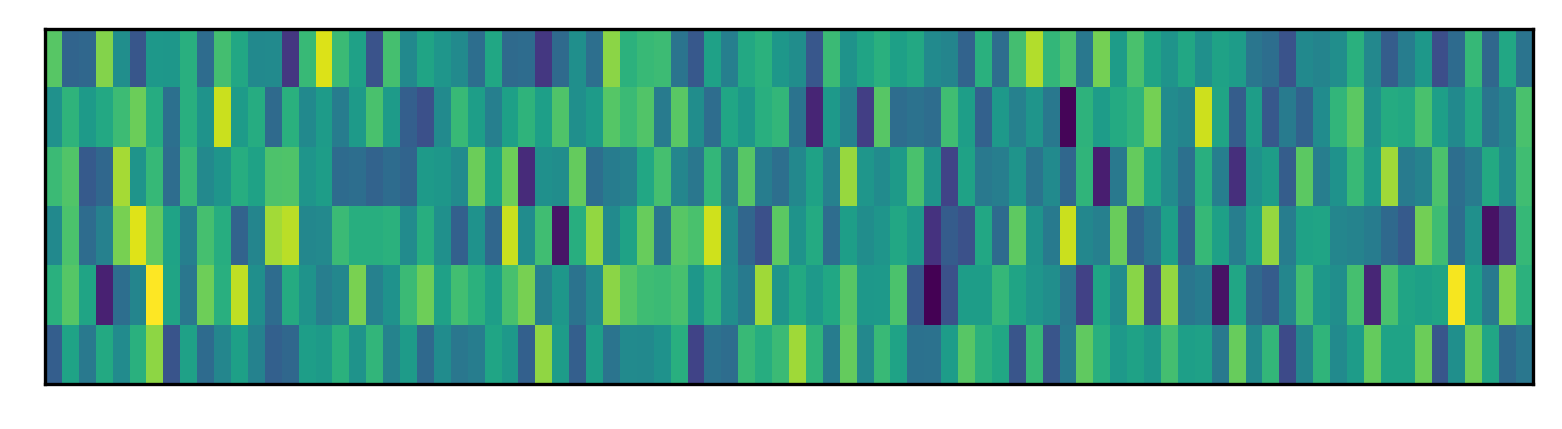

In [7]:
def show_matrix(mat, fname:str=""):
    """Visualize the matrix"""
    fig, ax = plt.subplots(dpi=300)
    ax.imshow(mat.T, aspect=3.5)
    ax.set(
        xticklabels=[],
        xticks=[],
        yticklabels=[],
        yticks=[],
    )
    if fname:
        fig.savefig(fname, bbox_inches='tight')
    return fig

show_matrix(
    noised_angles,
    "../plots/pdb_structures/noising_visualization/fully_noised_values.pdf"
).show()

In [8]:
clean_view, clean_angles = visualize_training_example(
    i=56, timestep=0,
    struct_pdb="../plots/pdb_structures/noising_visualization/clean.pdb",
)
clean_view

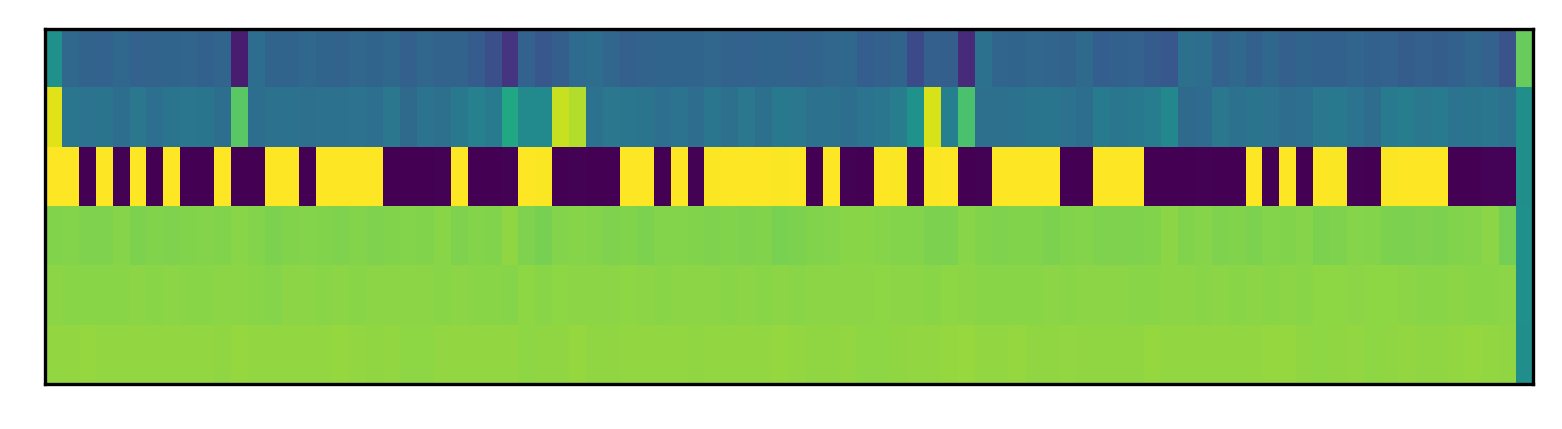

In [9]:
show_matrix(
    clean_angles,
    "../plots/pdb_structures/noising_visualization/clean_values.pdf"
).show()

## Look at reconstruction within training examples

In [10]:
# Look at the full defined set, or 4 angles we currently fit, or 3 dihedrals

angle_sets_to_evaluate = [
    ["phi", "psi", "omega", "tau", "CA:C:1N", "C:1N:1CA"],
    ["phi", "psi", "omega", "tau"], 
    ["phi", "psi", "omega"],
]

# Look at either all the distances or none of them
dist_sets_to_evaluate = [
    ["0C:1N", "N:CA", "CA:C"],
    []
]

# Combinatorially look at these angle sets
def evaluate_angle_set_parallel(filenames, angles, dists):
    warnings.filterwarnings('ignore', '.*elements were guessed from atom_name.*')
    warnings.filterwarnings('ignore', '.*invalid value encountered in true_div.*')
    pfunc = functools.partial(
        test_consistency,
        angles_to_use=angles,
        dists_to_use=dists,
    )
    pool = multiprocessing.Pool(multiprocessing.cpu_count())
    tm_scores = np.array([score for score, _view in pool.map(pfunc, filenames, chunksize=20)])
    pool.close()
    pool.join()
    return tm_scores

human_readable_angle_combos = [
    r"dihedrals, angles, and distances",
    r"dihedrals and angles",
    r"dihedrals, $\theta_1$, and distances",
    r"dihedrals, $\theta_1$",
    r"dihedrals, distances",
    r"dihedrals only"
]
per_angle_dist_results = {}
for human_name, (a, d) in zip(human_readable_angle_combos, itertools.product(angle_sets_to_evaluate, dist_sets_to_evaluate)):
    print(human_name, a, d)
    per_angle_dist_results[human_name] = evaluate_angle_set_parallel(train_dset.filenames[:5000], angles=a, dists=d)

dihedrals, angles, and distances ['phi', 'psi', 'omega', 'tau', 'CA:C:1N', 'C:1N:1CA'] ['0C:1N', 'N:CA', 'CA:C']


dihedrals and angles ['phi', 'psi', 'omega', 'tau', 'CA:C:1N', 'C:1N:1CA'] []


dihedrals, $\theta_1$, and distances ['phi', 'psi', 'omega', 'tau'] ['0C:1N', 'N:CA', 'CA:C']


dihedrals, $\theta_1$ ['phi', 'psi', 'omega', 'tau'] []


dihedrals, distances ['phi', 'psi', 'omega'] ['0C:1N', 'N:CA', 'CA:C']


dihedrals only ['phi', 'psi', 'omega'] []


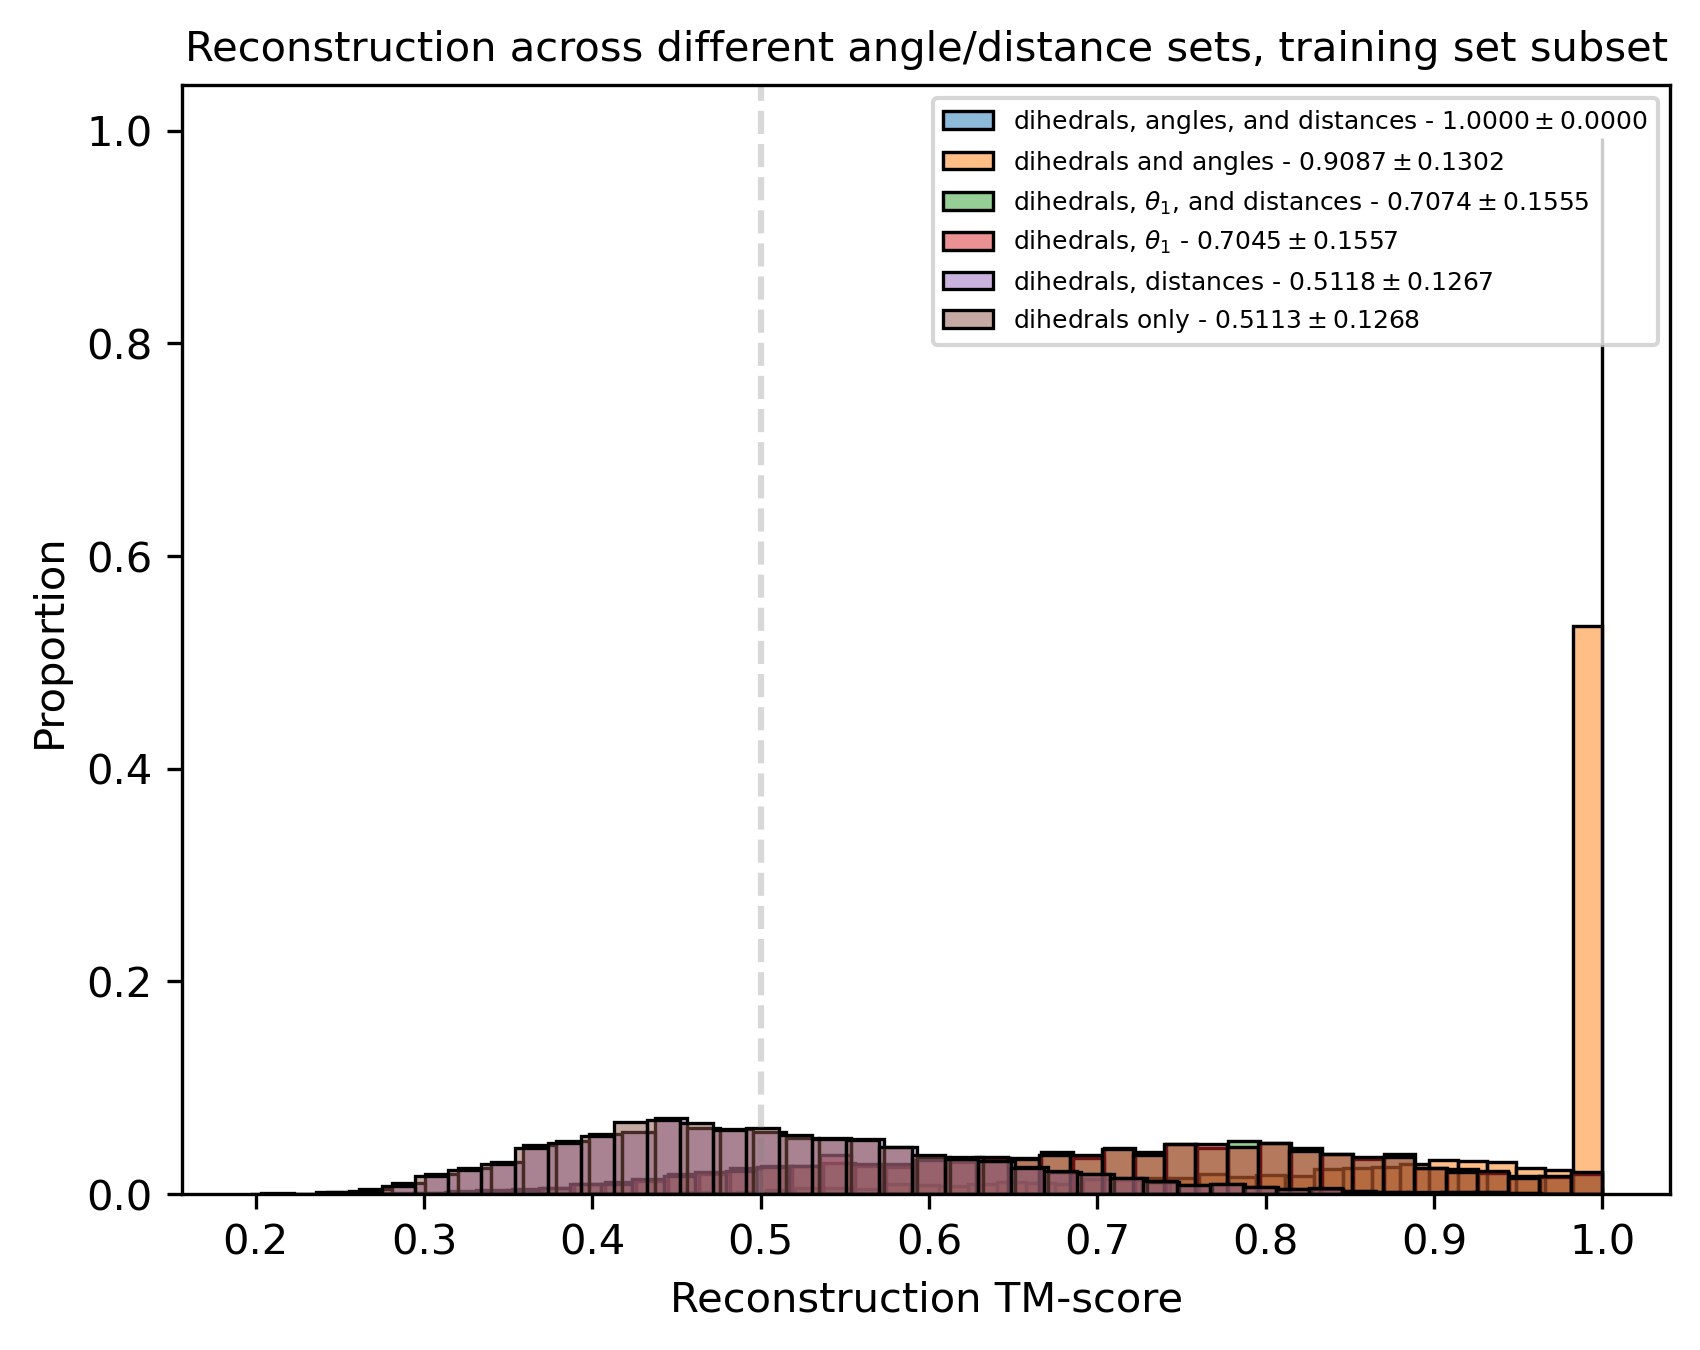

In [11]:
# Plot these results
reconst_tmscore_dir = plotting.PLOT_DIR / "reconstruction_angles_coords"
if not reconst_tmscore_dir.is_dir():
    os.makedirs(reconst_tmscore_dir)

fig, ax = plt.subplots(dpi=300)
for i, (k, v) in enumerate(per_angle_dist_results.items()):
    c = [
        'tab:blue',
        'tab:orange',
        'tab:green',
        'tab:red',
        'tab:purple',
        'tab:brown',
    ][i]
    mean = np.nanmean(v)
    std = np.nanstd(v)
    sns.histplot(v, bins=40, stat='proportion', ax=ax, label=f"{k} - ${mean:.4f} \pm {std:.4f}$", alpha=0.5, color=c)
ax.axvline(0.5, color='grey', alpha=0.3, linestyle='--')
ax.legend(prop={'size': 6})
ax.set(
    xlabel="Reconstruction TM-score",
)
ax.set_title("Reconstruction across different angle/distance sets, training set subset", fontsize=10)
fig.savefig(reconst_tmscore_dir / "reconstruction_distributions.pdf", bbox_inches='tight')
fig.show()

In [12]:
reconstruction_scores = pd.DataFrame(
    per_angle_dist_results
)
reconstruction_scores

,"dihedrals, angles, and distances",dihedrals and angles,"dihedrals, $\theta_1$, and distances","dihedrals, $\theta_1$","dihedrals, distances",dihedrals only
0,1.0,0.99786,0.68215,0.67831,0.47946,0.47290
1,1.0,0.99917,0.96752,0.96936,0.75964,0.76094
2,1.0,0.86762,0.49919,0.47053,0.35275,0.35238
3,1.0,0.91800,0.64134,0.63651,0.53123,0.53156
4,1.0,0.87263,0.56994,0.57017,0.37127,0.37552
...,...,...,...,...,...,...
4995,1.0,0.98508,0.48795,0.49039,0.43345,0.43008
4996,1.0,0.81243,0.73086,0.64326,0.51072,0.43845
4997,1.0,0.69481,0.53674,0.55092,0.41735,0.44795
4998,1.0,0.99855,0.87207,0.87069,0.48710,0.48938


In [13]:
np.nanmean(reconstruction_scores, axis=0), np.nanstd(reconstruction_scores, axis=0)

(array([0.99999991, 0.90867437, 0.70737945, 0.70446026, 0.51181834,
        0.5112916 ]),
 array([1.51441362e-06, 1.30244059e-01, 1.55532780e-01, 1.55658740e-01,
        1.26732712e-01, 1.26774429e-01]))

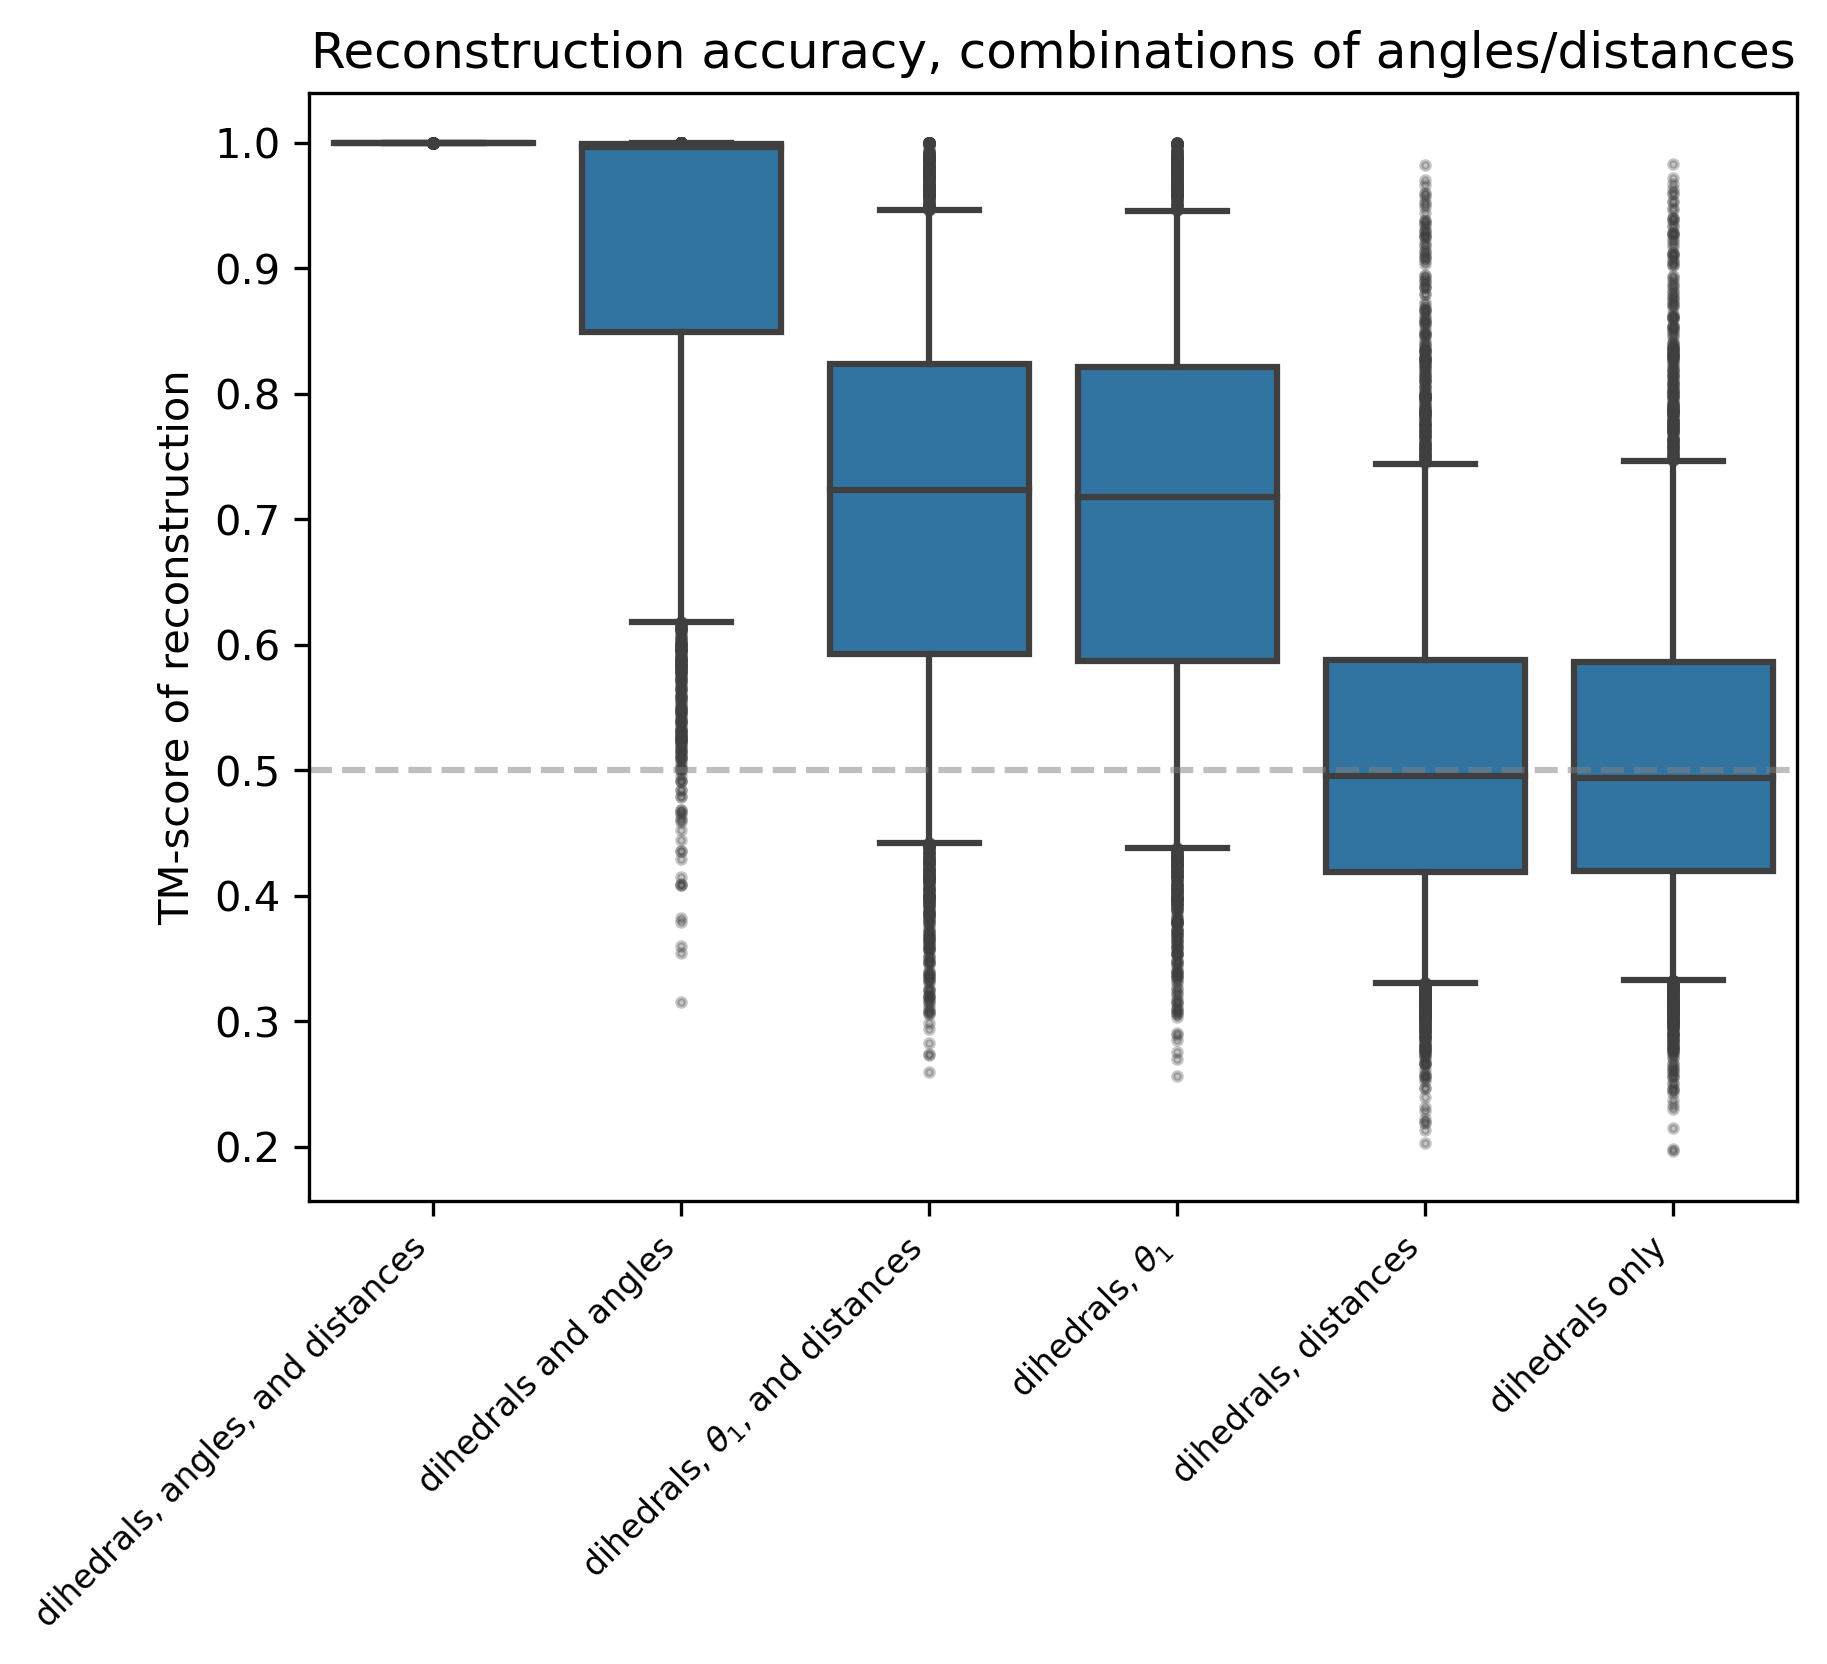

In [60]:
fig, ax = plt.subplots(dpi=300)
sns.boxplot(
    data=reconstruction_scores,
    whis=(5, 95),
    color=sns.color_palette()[0],
    fliersize=2,
    flierprops={"marker": "o", "alpha": 0.3, "color": "gray"},
)
ax.set_xticks(list(range(6)))
ax.set_xticklabels(reconstruction_scores.columns, rotation=45, ha='right', size=8)
ax.axhline(0.5, linestyle='--', color='grey', alpha=0.5)
ax.set(
    ylabel="TM-score of reconstruction",
    title="Reconstruction accuracy, combinations of angles/distances",
)
fig.savefig(reconst_tmscore_dir / "reconstruction_barplot.pdf", bbox_inches='tight')
fig.show()

In [15]:
train_dset_seq_lens = np.array([train_dset[i]['lengths'].item() for i in range(5000)])
train_dset_seq_lens

array([ 97, 109, 128, ..., 128, 128,  93])

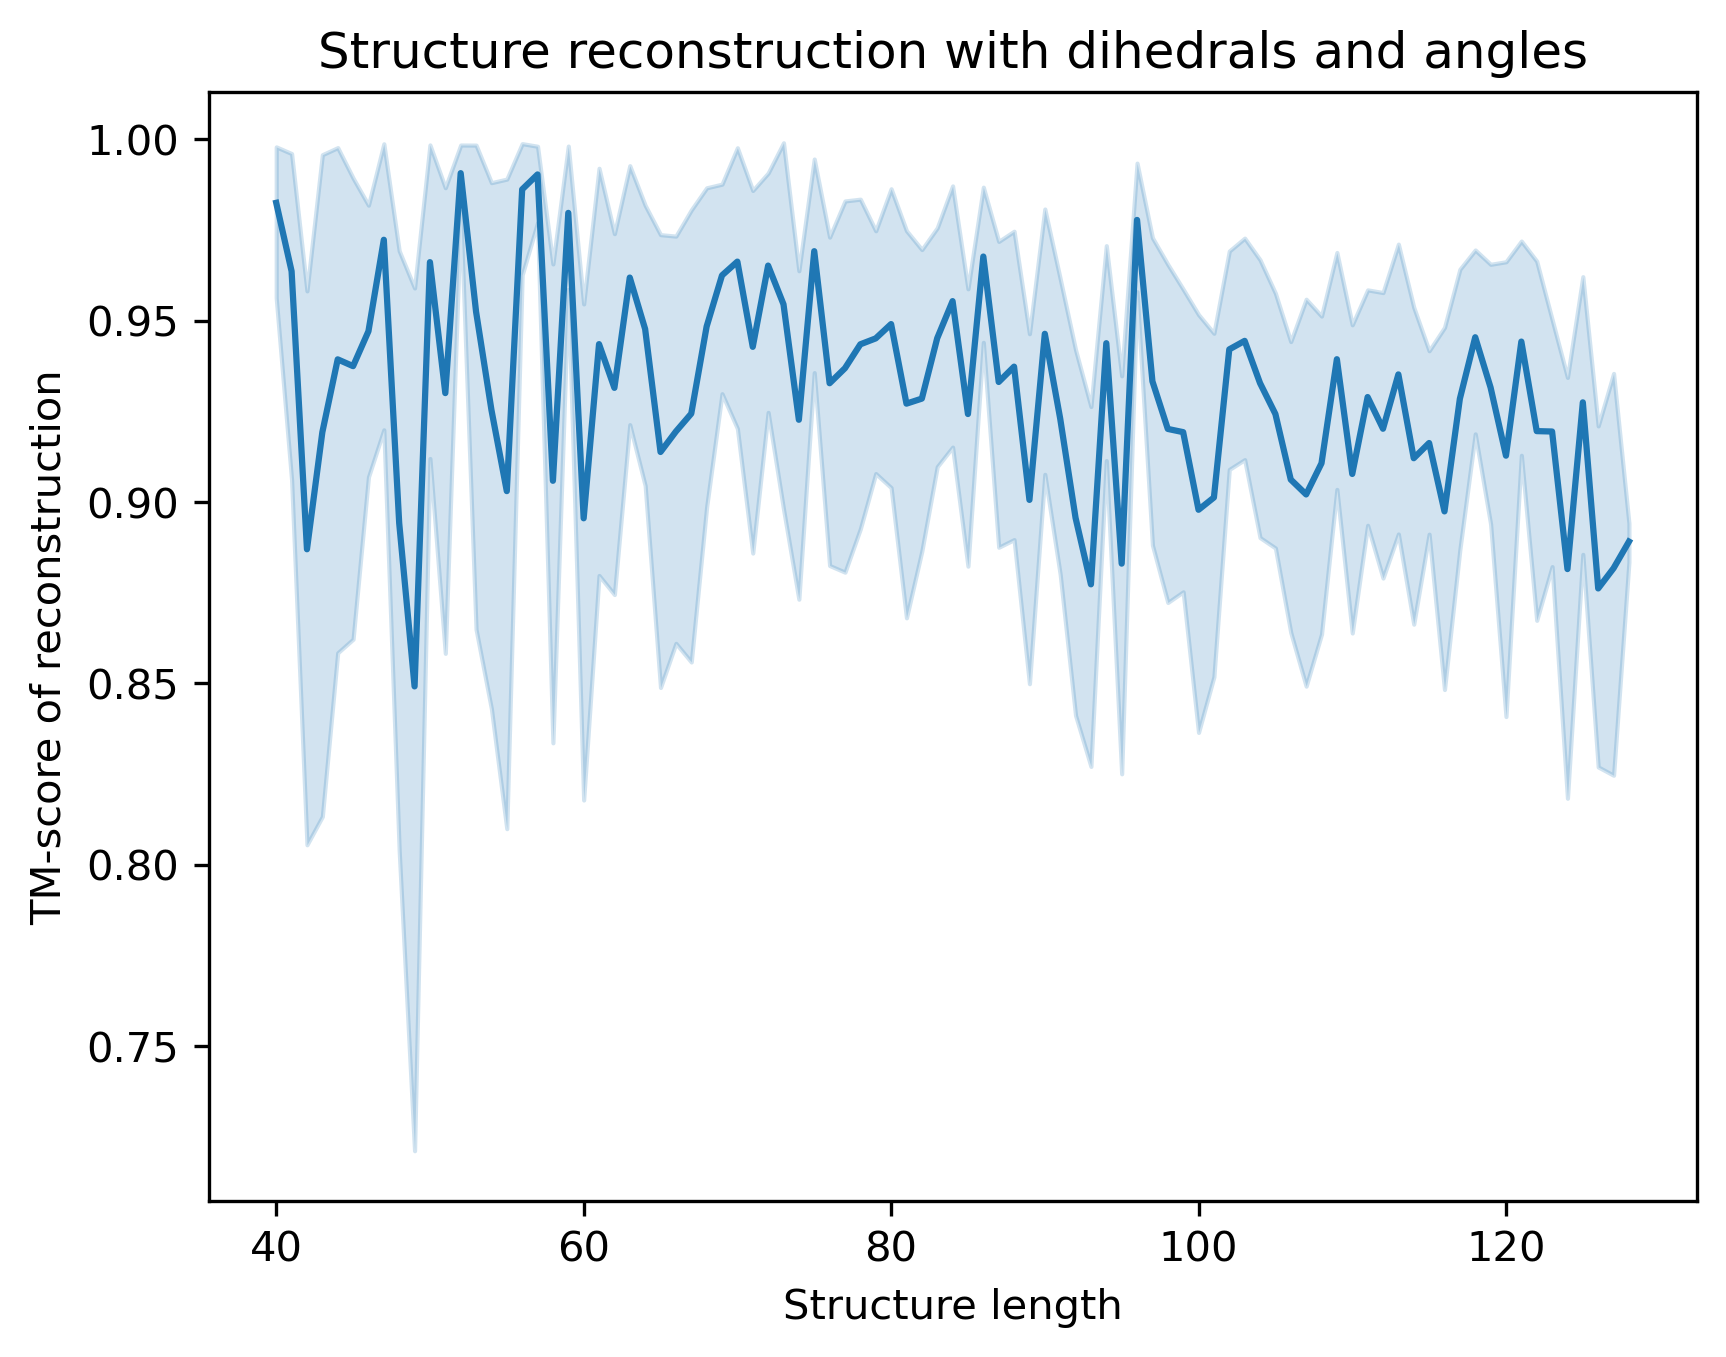

In [16]:
fig, ax = plt.subplots(dpi=300)
sns.lineplot(
    x=train_dset_seq_lens,
    y=reconstruction_scores['dihedrals and angles'],
    ax=ax,
)
ax.set(
    xlabel="Structure length",
    ylabel="TM-score of reconstruction",
    title="Structure reconstruction with dihedrals and angles",
)
fig.savefig(
    reconst_tmscore_dir / "reconstruction_by_len.pdf", bbox_inches='tight'
)
fig.show()

In [17]:
train_dset_seq_lens

array([ 97, 109, 128, ..., 128, 128,  93])

In [18]:
nonnan_idx = np.where(~np.isnan(reconstruction_scores['dihedrals and angles'].values))
stats.spearmanr(train_dset_seq_lens[nonnan_idx], reconstruction_scores['dihedrals and angles'].values[nonnan_idx])

SpearmanrResult(correlation=-0.18299908936829787, pvalue=7.193951217565667e-39)